---
title: Constructing an AR Dataset

author: Jimmy Butler
subtitle: A notebook to demonstrate workflows to ascribe characteristics and impacts to landfalling ARs in a catalog of AR storm events.
---

## Setup

First, we'll load up any packages and modules we might need.

In [1]:
# load external packages

import os
import pandas as pd
import xarray as xr
from pathlib import Path
import earthaccess
import ray
from tqdm import tqdm

In [2]:
# load internal helper modules

from utils.loading_utils import load_ais, load_cell_areas, EarthdataGatekeeper
from utils.display_utils import display_catalog
from utils.attribute_utils import *
from utils.compute_attributes_streaming import *

Next, let's load up the catalog. We'll be using a subset of the full version for now (the first 250 landfalling storms, out of ~3000 total).

In [3]:
# load the dataset

storms = pd.read_hdf('catalog/subset_storms.h5')

Finally, we load up a mask of grid cells for Antarctica, as well as a mapping of grid cell to cell area.

In [4]:
ais_mask = load_ais()
cell_areas = load_cell_areas()

## Catalog Overview

Before we get started with the masking workflow, we can first take a quick look at the catalog. The catalog is a clustering of AR pixels identified in the [Wille (2021) catalog](https://doi.org/10.5281/zenodo.4009663), which takes an Eulerian approach to identifying atmoshperic rivers.

,data_array,is_landfalling
cluster,,
1,,True
4,,True
5,,True
6,,True
11,,True

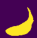
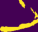

In [5]:
display_catalog(storms, 5)

The `storms` object is a `pandas.DataFrame`, with rows corresponding to different identified AR storm events that made landfall. The `data_array` column contains binary-valued `xarray.DataArray` masks of the full spatiotemporal footprint of the storm. Note, we must use the `display_catalog` function from our local `display_utils` module to view the dataframe. Otherwise, if one attempts to print the dataframe as usual, the `data_array` column will be filled with string representations of the masks which (1) take forever to render and (2) are unpleasant to look at.

In [6]:
storms.loc[1].data_array

<xarray.DataArray 'clust' (time: 15, lat: 72, lon: 71)> Size: 77kB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(15, 72, 71), dtype=int8)
Coordinates:
  * time     (time) datetime64[ns] 120B 1980-01-02 ... 1980-01-03T18:00:00
  * lat      (lat) float64 576B -74.5 -74.0 -73.5 -73.0 ... -40.0 -39.5 -39.0
  * lon      (lon) float64 568B -119.4 -118.8 -118.1 ... -76.88 -76.25 -75.62

Organizing the catalog in this way means we can appeal to `pandas` very powerful and compact API to compute relevant storm quantities.

## Filling in Storm Attributes and Impacts

Now let's put these masks to good use and start grabbing interesting quantities associated with each storm. There are two kinds of quantities we can compute, ones which need reanalysis data (geographic attributes, when and where, etc.) and ones which don't (atmospheric quantities). We'll start with computing quantities that don't yet require reanalysis data and finish with a fully cloud-based workflow to compute quantities that do require reanalysis.

### Geographic Quantities

Let's start with computing geographic attributes of each landfalling storm. This includes the following quantities:
+ `max_area`: the largest areal extent of the storm over its complete lifetime
+ `mean_landfalling_area`: the average landfalling areal extent of the storm
+ `cumulative_landfalling_area`: the cumulative time x space the storm spent over the ice sheet
+ `duration`: how long did it last
+ `start_date`: when did the storm first appear
+ `end_date`: when did it dissipate
+ `max_south_extent`: how far south did it go, in degrees latitude?
+ `region`: the region of Antarctica it made landfall in (either `West`, `East 1`, or `East 2`)

Helper functions to compute each of these attributes given a storm's `xarray.DataArray` can be found in the `attributes_utils` module.

In [7]:
storms['max_area'] = storms['data_array'].apply(lambda x: compute_max_area(x, cell_areas))
storms['mean_landfalling_area'] = storms['data_array'].apply(lambda x: compute_mean_area(x, cell_areas, ais_mask))
storms['cumulative_landfalling_area'] = storms['data_array'].apply(lambda x: compute_cumulative_spacetime(x, cell_areas, ais_mask))
storms['duration'] = storms['data_array'].apply(compute_duration)
storms['start_date'] = storms['data_array'].apply(add_start_date)
storms['end_date'] = storms['data_array'].apply(add_end_date)
storms['max_south_extent'] = storms['data_array'].apply(compute_max_southward_extent)

In [8]:
# regions defined by ranges of longitudes
region_defs = {'West': [-150, -30], 
               'East 1': [-30, 75],
               'East 2': [75, -150]}
region_masks = find_region_masks(region_defs, ais_mask)
storms['region'] = storms['data_array'].apply(lambda x: find_landfalling_region(x, cell_areas, region_masks))

Let's take a look at what we were able to create.

,data_array,is_landfalling,max_area,mean_landfalling_area,cumulative_landfalling_area,duration,start_date,end_date,max_south_extent,region
cluster,,,,,,,,,,
1,,True,1906980.773475,14234.801359,26690.252548,1 days 21:00:00,1980-01-02 00:00:00,1980-01-03 18:00:00,-74.500000,West
4,,True,1755659.732930,190118.717570,332707.755748,1 days 21:00:00,1980-01-06 18:00:00,1980-01-08 12:00:00,-74.000000,East 2
5,,True,83382.544344,83382.544344,10422.818043,0 days 03:00:00,1980-01-08 12:00:00,1980-01-08 12:00:00,-79.500000,East 1
6,,True,1429138.802826,1429138.802826,178642.350353,0 days 03:00:00,1980-01-09 15:00:00,1980-01-09 15:00:00,-83.500000,East 2
11,,True,735749.686485,210763.105430,52690.776358,0 days 06:00:00,1980-01-11 12:00:00,1980-01-11 15:00:00,-85.000000,West

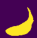
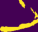

In [9]:
display_catalog(storms, 5)

### Atmospheric Quantities

Now for the more interesting part, let's compute atmospheric characteristics and attributes for each storm. This includes things like their landfalling moisture content, wind speeds, as well as their impacts, like cumulative snowfall on the ice sheet or maximum surface temperature anomaly.

We'll be using MERRA-2 reanalysis data to get these quantities. Of course, one might just execute this workflow by loading it up from disk at some local file system you have accxess to, but that's not very reproducible, accessible, or open! Instead, we'll be streaming MERRA-2 from AWS S3 buckets using `earthaccess`, a workflow that is much more reproducible, accessible, open, and lightweight!

:::{attention}

To access MERRA-2 data in the cloud, you'll need to first create a NASA Earthdata account and create the relevant [Earthdata prerequisite files](https://github.com/nasa/gesdisc-tutorials/blob/main/notebooks/How_to_Generate_Earthdata_Prerequisite_Files.ipynb), most notably the `.netrc` file with your Earthdata login credentials. You will also need to be in the AWS `us-west-2` region to stream from s3. If you are running this notebook on CryoCloud, you are in `us-west-2`.

:::

We'll first define a dictionary mapping to the DOIs of the MERRA-2 datasets we will be using.

In [10]:
data_dois = {'climatology': '10.5067/5ESKGQTZG7FO',
             'T2M_TQV_SLP': '10.5067/3Z173KIE2TPD',
             'VFLXQV_PRECIP': '10.5067/Q5GVUVUIVGO7',
             'V850': '10.5067/VJAFPLI1CSIV',
             'OMEGA': '10.5067/QBZ6MG944HW0'}

#### Climatology

A couple of the characteristics we want to compute are anomalies, such as the maximum landfalling 2m temperature anomaly underneath the footprint of the AR, as well as integrated water vapor anomaly. We'll compute the climatology of both of these variables via streaming first.

In [15]:
# search for the data granules
# CHANGE BACK TO 2022
granule_lst = earthaccess.search_data(doi=data_dois['climatology'], 
                                  temporal=('1980-01-01', '1983-12-31'))

In [18]:
pointers = earthaccess.open(granule_lst, show_progress=False)

In [20]:
monthly_means = xr.open_mfdataset(pointers)

ValueError: found the following matches with the input file in xarray's IO backends: ['h5netcdf']. But their dependencies may not be installed, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

In [6]:
num_cpus = 4

Now, let's load up the auxiliary datasets that will help us compute our relevant AR characteristics and impacts.

Now, let's compute our climatologies, which we will later use to compute temperature and IWV anomalies. We'll just compute the climatology dataset and store it memory, partially because it's not that huge, and also because if we leave it to be executed until it's time to compute anomalies for the individual ARs, we may be repeating our anomaly computations multiple times. This will help us save on time.

:::{attention}
Either we can run the next cell to create the climatology dataset, which should take about 15 minutes to do. Or, you could run this just once, save it, and just load it up from disk for future runs.
:::

Now, we write a function to setup our Ray instance to do our parallel processing.

In [9]:
def setup_ray(func_vars_dict):
    '''
    Function that serves to stop the previous chunk's ray cluster, clear its memory,
        and start a new one for a new chunk. Also initializes the gatekeeper for
        making open requests to Earthdata, and stores bigger objects into Ray's
        object store for more efficient sharing of these objects across clusters.

    Inputs:
        func_vars_dict (dict of dict): outer layer of dictionary keys are names of variables in
            MERRA-2 datasets, inner layer are names of desired aggregates of those variables as keys,
            along with their aggregation functions as values.
    '''
    
    # shutdown and restart the ray cluster, to clear memory
    if ray.is_initialized():
        ray.shutdown()
    
    ray.init(num_cpus=num_cpus, logging_level='ERROR', 
         _metrics_export_port=None, include_dashboard=False, 
         log_to_driver=False, runtime_env={'py_modules': [attribute_utils, loading_utils, st_dbscan]})

    climatology_ref = ray.put(climatology_ds)
    cell_areas_ref = ray.put(cell_areas)
    func_vars_ref = ray.put(func_vars_dict)

    return climatology_ref, cell_areas_ref, func_vars_ref
    

## Masking Quantities from `10.5067/3Z173KIE2TPD`

This includes IWV, IWV anomaly, 2m-temperature, 2m-temperature anomaly, and sea level pressure quantities.

We arrange our `func_vars_dict` variable in the following way so that, if there are multiple quantities and aggregations we wish to compute on the same variable DataArray, we compute all of them on the same streamed object instead of throwing it away and restreaming for each additional quantity.

In [10]:
func_vars_dict1 = {'T2M': {'max_T2m_ais': lambda storm_da, var_da, area_da: compute_max_intensity(storm_da, var_da, area_da, ais_mask),
                          'max_T2M_anomaly_ais': lambda storm_da, var_da, area_da: compute_max_intensity(storm_da, var_da, area_da, ais_mask)},
                  'TQV': {'avg_IWV_ais': lambda storm_da, var_da, area_da: compute_average(storm_da, var_da, area_da, ais_mask),
                          'max_IWV_ais': lambda storm_da, var_da, area_da: compute_max_intensity(storm_da, var_da, area_da, ais_mask),
                          'max_IWV_anomaly_ais': lambda storm_da, var_da, area_da: compute_max_intensity(storm_da, var_da, area_da, ais_mask)},
                  'SLP': {'max_ocean_SLP_gradient': lambda storm_da, var_da, area_da: compute_max_SLPgrad(storm_da, var_da, area_da, ais_mask)}
                 }

data_doi = data_dois['T2M_TQV_SLP']
progress_log_path = 'T2M_TQV_SLP_logs'

missing_days1 = []
parallel_results1 = []

for i, chunk_inds in enumerate(chunk_inds_lst):

    storms_chunk = landfalling_storms.iloc[chunk_inds]
    climatology_ref, cell_areas_ref, func_vars_ref = setup_ray(func_vars_dict1)
    gatekeeper = EarthdataGatekeeper.remote()

    result_refs = []
    for index, row in storms_chunk.iterrows():
        result_refs.append(compute_summaries.remote(
            row.data_array,
            func_vars_ref,
            cell_areas_ref,
            data_doi,
            gatekeeper=gatekeeper,
            climatology_ds=climatology_ref))


    with open(f'{progress_log_path}/streaming_progress{i+1}.log', "w") as log_file:
        parallel_results = []
        missing_days = []
        for ref in tqdm(result_refs, total=len(result_refs), file=log_file, miniters=miniters):
            results = ray.get(ref)
            parallel_results.append(results[0])
            missing_days.append(results[1])

    parallel_results1 = parallel_results1 + parallel_results
    missing_days1 = missing_days1 + missing_days

    ray.shutdown()

/home/jovyan/envs/antarctic_ars/lib/python3.12/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
[2025-12-05 05:11:27,397 E 97 441] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-12-05 05:20:09,315 E 97 5430] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-12-05 05:28:46,962 E 97 10900] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. 

In [11]:
labels1 = [key for quantity_dict in func_vars_dict1.values() for key in quantity_dict.keys()]

In [12]:
df1 = pd.DataFrame(parallel_results1, columns=labels1)
df1['T2M_TQV_SLP_missing'] = missing_days1
df1.to_csv('streamed_datasets/streamed_T2M_TQV_SLP.csv', index=False)

## Masking Quantities from `10.5067/Q5GVUVUIVGO7`

This includes IVT and precipitation quantities (rainfall, snowfall). Starting with IVT.

In [15]:
func_vars_dict2 = {'VFLXQV': {'avg_vIVT_ais': lambda storm_da, var_da, area_da: compute_average(storm_da, -var_da, area_da, ais_mask),
                             'max_vIVT_ais': lambda storm_da, var_da, area_da: compute_max_intensity(storm_da, -var_da, area_da, ais_mask),
                             'avg_vIVT': lambda storm_da, var_da, area_da: compute_average(storm_da, -var_da, area_da),
                             'max_vIVT': lambda storm_da, var_da, area_da: compute_max_intensity(storm_da, -var_da, area_da)}}
data_doi = data_dois['VFLXQV_PRECIP']
progress_log_path = 'VFLXQV_logs'

In [16]:
missing_days2 = []
parallel_results2 = []

for i, chunk_inds in enumerate(chunk_inds_lst):

    storms_chunk = landfalling_storms.iloc[chunk_inds]
    climatology_ref, cell_areas_ref, func_vars_ref = setup_ray(func_vars_dict2)
    gatekeeper = EarthdataGatekeeper.remote()

    result_refs = []
    for index, row in storms_chunk.iterrows():
        result_refs.append(compute_summaries.remote(
            row.data_array,
            func_vars_ref,
            cell_areas_ref,
            data_doi,
            gatekeeper=gatekeeper,
            half_hour=True))


    with open(f'{progress_log_path}/streaming_progress{i+1}.log', "w") as log_file:
        parallel_results = []
        missing_days = []
        for ref in tqdm(result_refs, total=len(result_refs), file=log_file, miniters=miniters):
            results = ray.get(ref)
            parallel_results.append(results[0])
            missing_days.append(results[1])

    parallel_results2 = parallel_results2 + parallel_results
    missing_days2 = missing_days2 + missing_days

    ray.shutdown()

%%capture output2

[2025-12-05 06:11:06,023 E 97 36130] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


KeyboardInterrupt: 

In [ ]:
labels2 = [key for quantity_dict in func_vars_dict2.values() for key in quantity_dict.keys()]

In [ ]:
df2 = pd.DataFrame(parallel_results2, columns=labels2)
df2['VFLXQV_missing'] = missing_days2
df2.to_csv('streamed_datasets/streamed_VFLXQV.csv', index=False)

Now moving on to precipitation.

In [ ]:
data_doi = data_dois['VFLXQV_PRECIP']
progress_log_path = 'PRECIP_logs'

def precip_func(storm_da, var_da, area_da):
    return compute_cumulative(storm_da, var_da, area_da, ais_mask)

In [ ]:
missing_days3 = []
parallel_results3 = []

for i, chunk_inds in enumerate(chunk_inds_lst):

    storms_chunk = landfalling_storms.iloc[chunk_inds]
    climatology_ref, cell_areas_ref, precip_func_ref = setup_ray(precip_func)
    gatekeeper = EarthdataGatekeeper.remote()

    result_refs = []
    for index, row in storms_chunk.iterrows():
        result_refs.append(compute_precip_summaries.remote(
            row.data_array, 
            cell_areas_ref, 
            precip_func_ref,
            data_doi,
            gatekeeper=gatekeeper))


    with open(f'{progress_log_path}/streaming_progress{i+1}.log', "w") as log_file:
        parallel_results = []
        missing_days = []
        for ref in tqdm(result_refs, total=len(result_refs), file=log_file, miniters=miniters):
            results = ray.get(ref)
            parallel_results.append(results[0])
            missing_days.append(results[1])

    parallel_results3 = parallel_results3 + parallel_results
    missing_days3 = missing_days3 + missing_days

    ray.shutdown()

%%capture output3

In [ ]:
labels3 = ['cumulative_rainfall_ais', 'cumulative_snowfall_ais']

## Masking Quantities from `10.5067/VJAFPLI1CSIV`

This is for poleward 850 hPa wind.

In [ ]:
func_vars_dict4 = {'V850': {'max_landfalling_v850hPa': lambda storm_da, var_da, area_da: compute_max_landfalling_wind(storm_da, -var_da, area_da, ais_mask),
                           'avg_landfalling_v850hPa': lambda storm_da, var_da, area_da: compute_avg_landfalling_wind(storm_da, -var_da, area_da, ais_mask)}}
data_doi = data_dois['V850']
progress_log_path = 'V850_logs'

In [ ]:
missing_days4 = []
parallel_results4 = []

for i, chunk_inds in enumerate(chunk_inds_lst):

    storms_chunk = landfalling_storms.iloc[chunk_inds]
    climatology_ref, cell_areas_ref, func_vars_ref = setup_ray(func_vars_dict4)
    gatekeeper = EarthdataGatekeeper.remote()

    result_refs = []
    for index, row in storms_chunk.iterrows():
        result_refs.append(compute_summaries.remote(
            row.data_array,
            func_vars_ref,
            cell_areas_ref,
            data_doi,
            gatekeeper=gatekeeper,
            half_hour=True))


    with open(f'{progress_log_path}/streaming_progress{i+1}.log', "w") as log_file:
        parallel_results = []
        missing_days = []
        for ref in tqdm(result_refs, total=len(result_refs), file=log_file, miniters=miniters):
            results = ray.get(ref)
            parallel_results.append(results[0])
            missing_days.append(results[1])

    parallel_results4 = parallel_results4 + parallel_results
    missing_days4 = missing_days4 + missing_days

    ray.shutdown()

%%capture output4

In [ ]:
labels4 = [key for quantity_dict in func_vars_dict4.values() for key in quantity_dict.keys()]

## Masking Quantities from `10.5067/QBZ6MG944HW0`

This is for omega.

In [ ]:
func_vars_dict5 = {'OMEGA': {'avg_landfalling_minomega': lambda storm_da, var_da, area_da: compute_avg_landfalling_minomega(storm_da, var_da, area_da, ais_mask)}}
data_doi = data_dois['OMEGA']
progress_log_path = 'OMEGA_logs'

In [ ]:
missing_days5 = []
parallel_results5 = []

for i, chunk_inds in enumerate(chunk_inds_lst):

    storms_chunk = landfalling_storms.iloc[chunk_inds]
    climatology_ref, cell_areas_ref, func_vars_ref = setup_ray(func_vars_dict5)
    gatekeeper = EarthdataGatekeeper.remote()

    result_refs = []
    for index, row in storms_chunk.iterrows():
        result_refs.append(compute_summaries.remote(
            row.data_array,
            func_vars_ref,
            cell_areas_ref,
            data_doi,
            gatekeeper=gatekeeper))


    with open(f'{progress_log_path}/streaming_progress{i+1}.log', "w") as log_file:
        parallel_results = []
        missing_days = []
        for ref in tqdm(result_refs, total=len(result_refs), file=log_file, miniters=miniters):
            results = ray.get(ref)
            parallel_results.append(results[0])
            missing_days.append(results[1])

    parallel_results5 = parallel_results5 + parallel_results
    missing_days5 = missing_days5 + missing_days

    ray.shutdown()

%%capture output5

In [ ]:
labels5 = [key for quantity_dict in func_vars_dict5.values() for key in quantity_dict.keys()]

## Remaining Quantities

Computing remaining quantities that don't involve streaming any MERRA-2 data, just for completeness.

In [ ]:
landfalling_storms['max_area'] = landfalling_storms['data_array'].apply(lambda x: compute_max_area(x, cell_areas))
landfalling_storms['mean_area'] = landfalling_storms['data_array'].apply(lambda x: compute_mean_area(x, cell_areas))
landfalling_storms['mean_landfalling_area'] = landfalling_storms['data_array'].apply(lambda x: compute_mean_area(x, cell_areas, ais_mask))
landfalling_storms['cumulative_landfalling_area'] = landfalling_storms['data_array'].apply(lambda x: compute_cumulative_spacetime(x, cell_areas, ais_mask))
landfalling_storms['duration'] = landfalling_storms['data_array'].apply(compute_duration)
landfalling_storms['start_date'] = landfalling_storms['data_array'].apply(add_start_date)
landfalling_storms['end_date'] = landfalling_storms['data_array'].apply(add_end_date)
landfalling_storms['max_south_extent'] = landfalling_storms['data_array'].apply(compute_max_southward_extent)
landfalling_storms['max_elevation_grad'] = landfalling_storms['data_array'].apply(lambda x: compute_max_elevation_grad(x, elevation))

region_defs_coarser = {'West': [-150, -30], 
               'East 1': [-30, 75],
               'East 2': [75, -150]}

region_masks_coarser = find_region_masks(region_defs_coarser, ais_mask)

landfalling_storms['coarser_region'] = landfalling_storms['data_array'].apply(lambda x: find_landfalling_region(x, cell_areas, region_masks_coarser))

landfalling_storms['trajectory'] = landfalling_storms['data_array'].apply(extract_trajectory)

# add in the merra2 aggregates to the landfalling dataframe
landfalling_storms[labels1] = parallel_results1
landfalling_storms[labels2] = parallel_results2
landfalling_storms[labels3] = parallel_results3
landfalling_storms[labels4] = parallel_results4
landfalling_storms[labels5] = parallel_results5

# add in the missing days
landfalling_storms['T2M_TQV_SLP_missing'] = missing_days1
landfalling_storms['VFLXQV_missing'] = missing_days2
landfalling_storms['PRECIP_missing'] = missing_days3
landfalling_storms['V850_missing'] = missing_days4
landfalling_storms['OMEGA_missing'] = missing_days5

# save the dataframe
landfalling_storms.to_hdf(home_dir/'project/dataset/datasets/streamed_landfalling_storm_quantities_df.h5', key='df')